In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as st
import pickle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

In [2]:
# TensorFlow import with error checking
try:
    import tensorflow as tf
    from tensorflow.keras.models import Sequential, load_model
    from tensorflow.keras.layers import LSTM, Dense
    print("TensorFlow version:", tf.__version__)
    print("Keras version:", tf.keras.__version__)
except ImportError as e:
    print(f"Error importing TensorFlow: {e}")
    print("Please make sure TensorFlow is installed correctly.")


TensorFlow version: 2.10.0
Keras version: 2.10.0


In [3]:
# Load data
df = pd.read_csv(r"D:\1A Shiash\Projects\Car engine - Code Completed\engine_data_Manual.csv")



In [4]:
# Display basic information about the dataset
print(df.head(10))


   Engine rpm  Lub oil pressure  Fuel pressure  Coolant pressure  \
0         700          2.493592      11.790927          3.178981   
1         876          2.941606      16.193866          2.464504   
2         520          2.961746       6.553147          1.064347   
3         473          3.707835      19.510172          3.727455   
4         619          5.672919      15.738871          2.052251   
5        1221          3.989226       6.679231          2.214250   
6         716          3.568896       5.312266          2.461067   
7         729          3.845166      10.191126          2.362998   
8         845          4.877239       3.638269          3.525604   
9         824          3.741228       7.626214          1.301032   

   lub oil temp  Coolant temp  Engine Condition  
0     84.144163     81.632187                 1  
1     77.640934     82.445724                 0  
2     77.752266     79.645777                 1  
3     74.129907     71.774629                 1  
4

In [5]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21200 entries, 0 to 21199
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Engine rpm        21200 non-null  int64  
 1   Lub oil pressure  21200 non-null  float64
 2   Fuel pressure     21200 non-null  float64
 3   Coolant pressure  21200 non-null  float64
 4   lub oil temp      21200 non-null  float64
 5   Coolant temp      21200 non-null  float64
 6   Engine Condition  21200 non-null  int64  
dtypes: float64(5), int64(2)
memory usage: 1.1 MB
None


In [6]:
print(df.describe().round(3))

       Engine rpm  Lub oil pressure  Fuel pressure  Coolant pressure  \
count   21200.000         21200.000      21200.000         21200.000   
mean      795.589             3.322          6.559             2.327   
std       267.310             1.011          2.754             1.020   
min        61.000             0.003          0.003             0.002   
25%       597.000             2.541          4.773             1.619   
50%       751.000             3.217          6.099             2.114   
75%       942.000             4.030          7.656             2.825   
max      2239.000             7.266         21.138             7.479   

       lub oil temp  Coolant temp  Engine Condition  
count     21200.000     21200.000         21200.000  
mean         77.573        78.511             0.639  
std           3.075         6.122             0.480  
min          71.322        61.673             0.000  
25%          75.611        74.088             0.000  
50%          76.741        

In [8]:
print(df['Engine Condition'].value_counts())

Engine Condition
1    13551
0     7649
Name: count, dtype: int64


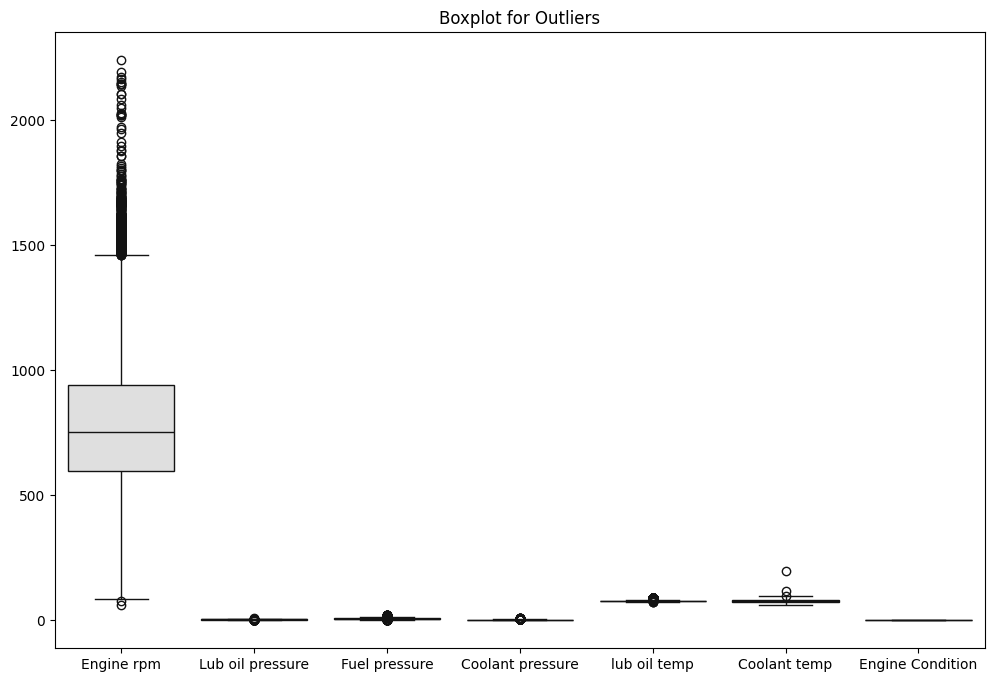

In [9]:
# Visualize outliers
plt.figure(figsize=(12, 8))
sns.boxplot(data=df, palette='binary')
plt.title("Boxplot for Outliers")
plt.show()



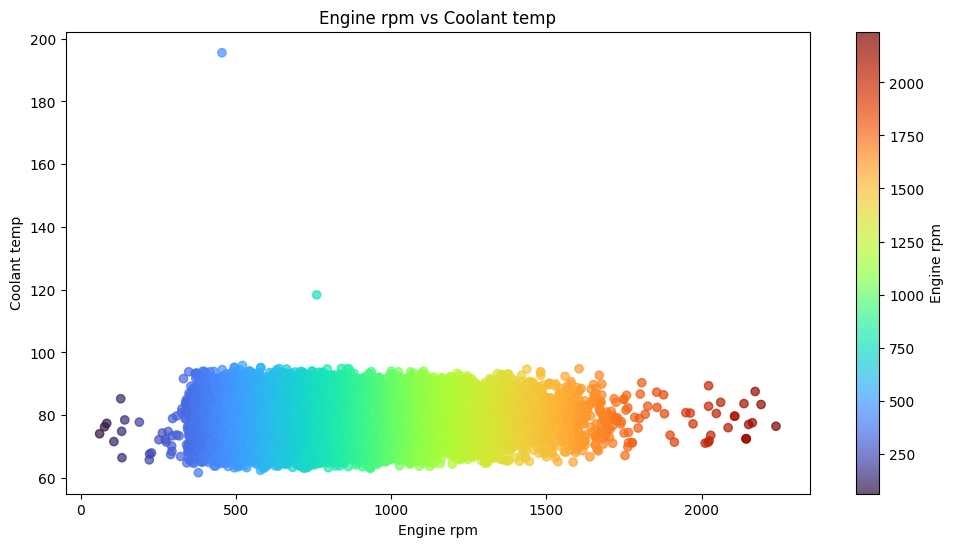

In [10]:
# Scatter plot
plt.figure(figsize=(12, 6))
scatter = plt.scatter(df["Engine rpm"], df["Coolant temp"], c=df["Engine rpm"], cmap='turbo', alpha=0.7)
plt.colorbar(scatter, label='Engine rpm')
plt.title("Engine rpm vs Coolant temp")
plt.xlabel("Engine rpm")
plt.ylabel("Coolant temp")
plt.show()



In [11]:
# Handle outliers using IQR
df_temp = df.drop(columns=["Engine Condition"])
Q1 = df_temp[['Engine rpm', 'Coolant temp']].quantile(0.25)
Q3 = df_temp[['Engine rpm', 'Coolant temp']].quantile(0.75)
IQR = Q3 - Q1
lower_limit = Q1 - 1.5*IQR
upper_limit = Q3 + 1.5*IQR
outlier_mask = (df[['Engine rpm', 'Coolant temp']] < lower_limit) | (df[['Engine rpm', 'Coolant temp']] > upper_limit)
outliers = df[outlier_mask.any(axis=1)]
print("Number of outliers:", len(outliers))
print("Percentage of data loss due to outlier removal:", (len(outliers) / len(df)) * 100)



Number of outliers: 442
Percentage of data loss due to outlier removal: 2.0849056603773586


In [12]:
# Remove outliers
df_cleaned = df[~outlier_mask.any(axis=1)]



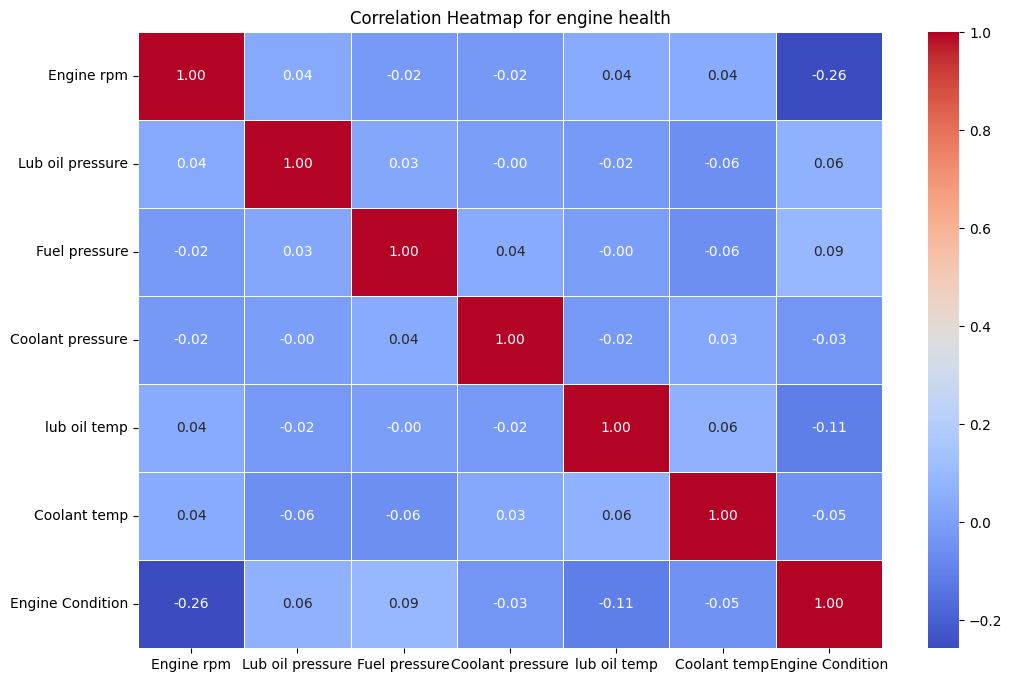

In [13]:
# Correlation heatmap
correlation = df_cleaned.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlation, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title("Correlation Heatmap for engine health")
plt.show()



In [14]:
# Prepare data for modeling
X = df_cleaned.drop(columns=["Engine Condition"])
Y = df_cleaned['Engine Condition']



In [15]:
# Split the data
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)



In [16]:
# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)



In [17]:
# Function to plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(12, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap="binary", cbar=False, xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
    plt.xlabel("Predicted Label")
    plt.ylabel("Actual Label")
    plt.title(title)
    plt.show()



KNN Accuracy: 66.01637764932563
KNN Classification Report:
              precision    recall  f1-score   support

           0       0.53      0.32      0.40      1471
           1       0.69      0.85      0.76      2681

    accuracy                           0.66      4152
   macro avg       0.61      0.58      0.58      4152
weighted avg       0.64      0.66      0.63      4152



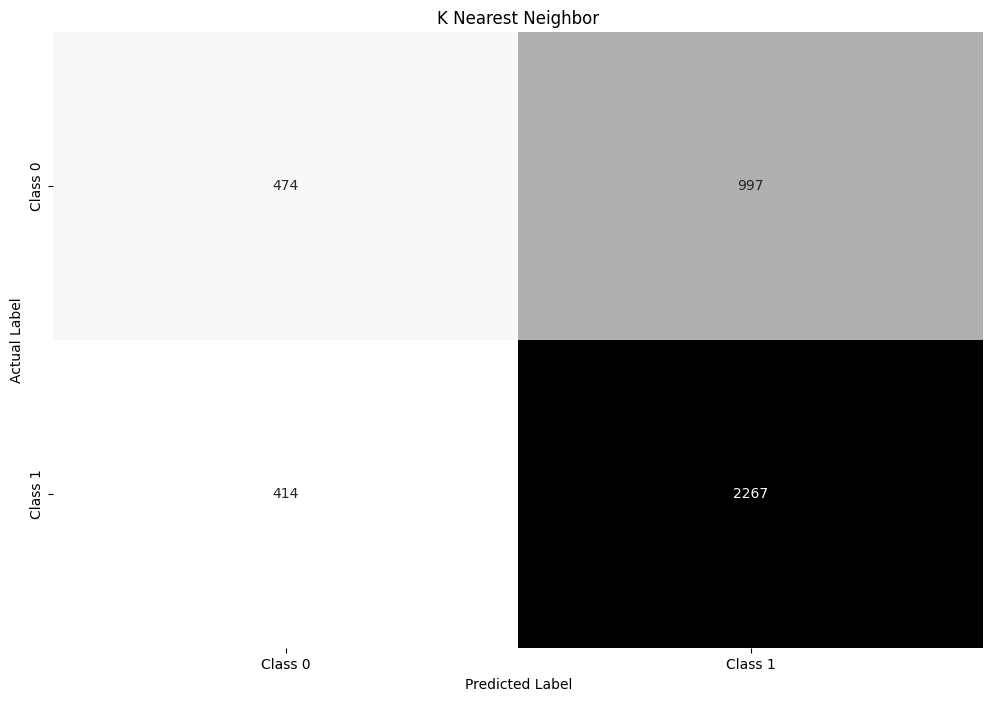

In [18]:
# KNN Model
knn = KNeighborsClassifier(n_neighbors=25)
knn.fit(X_train_scaled, Y_train)
knn_pred = knn.predict(X_test_scaled)
knn_accuracy = accuracy_score(Y_test, knn_pred)
print("KNN Accuracy:", knn_accuracy * 100)
print("KNN Classification Report:")
print(classification_report(Y_test, knn_pred))
plot_confusion_matrix(Y_test, knn_pred, "K Nearest Neighbor")



SVM Accuracy: 64.57129094412332
SVM Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1471
           1       0.65      1.00      0.78      2681

    accuracy                           0.65      4152
   macro avg       0.32      0.50      0.39      4152
weighted avg       0.42      0.65      0.51      4152



C:\Users\srini\AppData\Roaming\Python\Python310\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\srini\AppData\Roaming\Python\Python310\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\srini\AppData\Roaming\Python\Python310\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result)

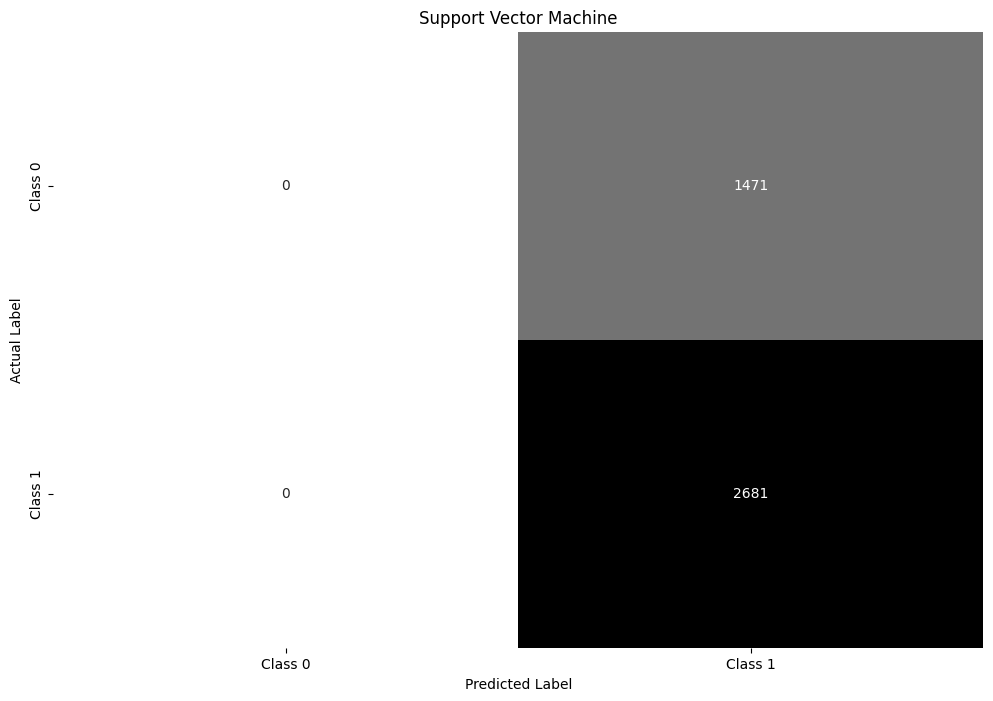

In [20]:
# SVM Model
svm = SVC(kernel="linear", C=1.0, degree=3, gamma="scale")
svm.fit(X_train_scaled, Y_train)
svm_pred = svm.predict(X_test_scaled)
svm_accuracy = accuracy_score(Y_test, svm_pred)
print("SVM Accuracy:", svm_accuracy * 100)
print("SVM Classification Report:")
print(classification_report(Y_test, svm_pred))
plot_confusion_matrix(Y_test, svm_pred, "Support Vector Machine")



Training original Random Forest...
Original Random Forest Accuracy: 68.4971098265896
Original Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.57      0.43      0.49      1471
           1       0.72      0.83      0.77      2681

    accuracy                           0.68      4152
   macro avg       0.65      0.63      0.63      4152
weighted avg       0.67      0.68      0.67      4152



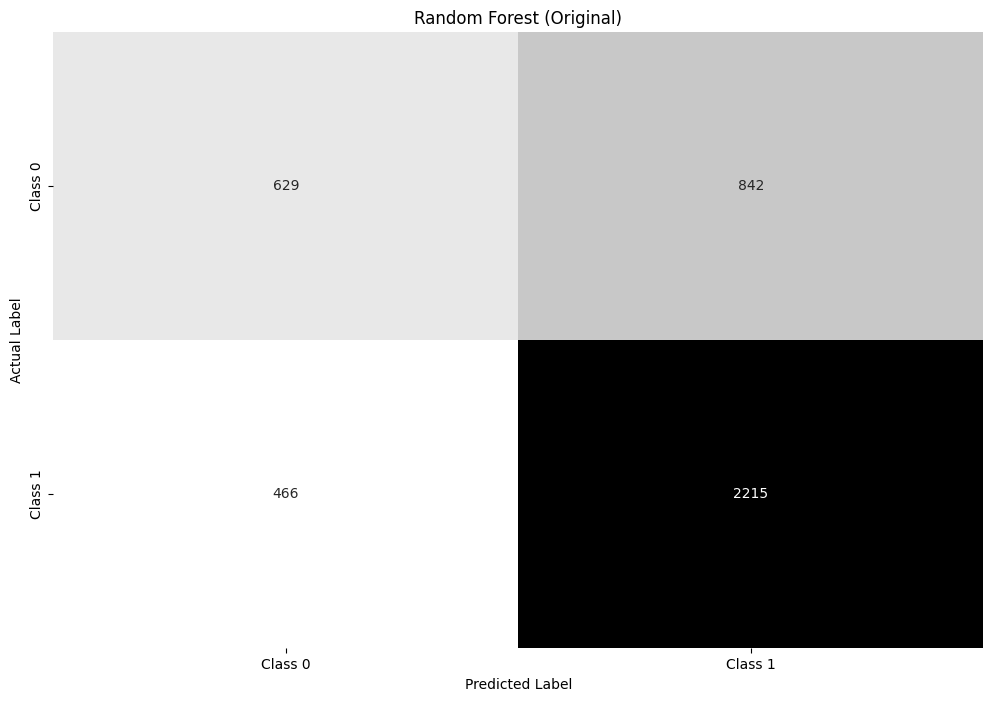

In [21]:
# Original Random Forest Model
print("Training original Random Forest...")
rdf = RandomForestClassifier(n_estimators=100, random_state=42)
rdf.fit(X_train_scaled, Y_train)
rdf_pred = rdf.predict(X_test_scaled)
rdf_accuracy = accuracy_score(Y_test, rdf_pred)
print("Original Random Forest Accuracy:", rdf_accuracy * 100)
print("Original Random Forest Classification Report:")
print(classification_report(Y_test, rdf_pred))
plot_confusion_matrix(Y_test, rdf_pred, "Random Forest (Original)")



Training Gradient Boosting Classifier...
Gradient Boosting Classifier Accuracy: 67.38921001926782
Gradient Boosting Classifier Classification Report:
              precision    recall  f1-score   support

           0       0.56      0.35      0.43      1471
           1       0.70      0.85      0.77      2681

    accuracy                           0.67      4152
   macro avg       0.63      0.60      0.60      4152
weighted avg       0.65      0.67      0.65      4152



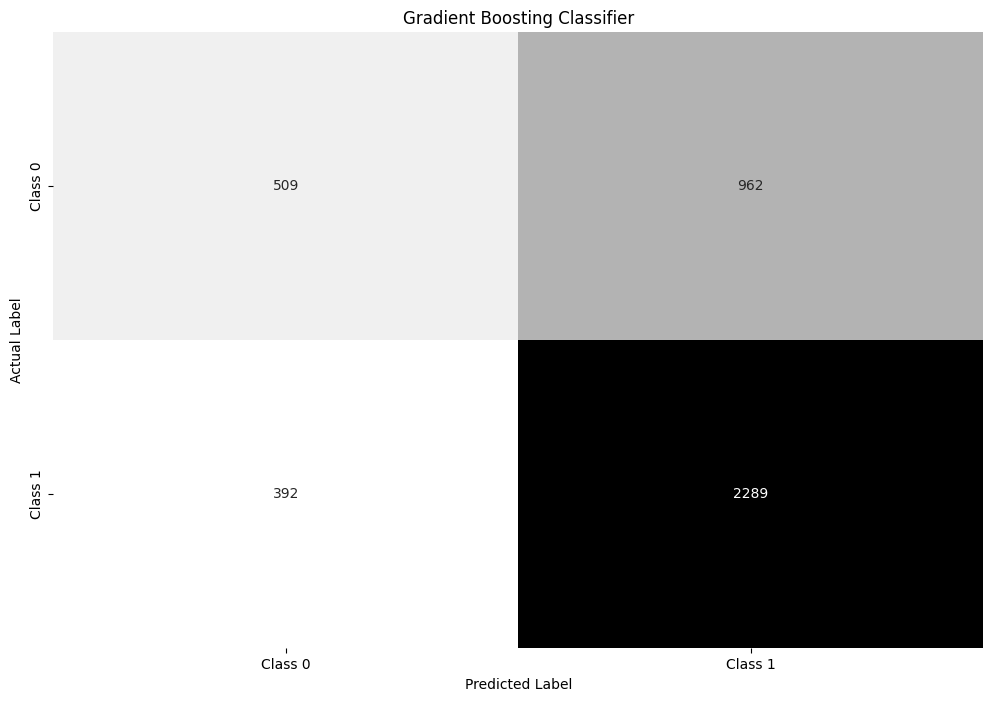

In [22]:
# Random Forest Model with GridSearchCV
# Gradient Boosting Classifier Model
print("Training Gradient Boosting Classifier...")
gbc = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
gbc.fit(X_train_scaled, Y_train)
gbc_pred = gbc.predict(X_test_scaled)
gbc_accuracy = accuracy_score(Y_test, gbc_pred)
print("Gradient Boosting Classifier Accuracy:", gbc_accuracy * 100)
print("Gradient Boosting Classifier Classification Report:")
print(classification_report(Y_test, gbc_pred))
plot_confusion_matrix(Y_test, gbc_pred, "Gradient Boosting Classifier")

c:\Users\srini\anaconda3\envs\Ten\lib\site-packages\xgboost\core.py:158: UserWarning: [11:37:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost Accuracy: 67.07610789980733
XGBoost Classification Report:
              precision    recall  f1-score   support

           0       0.55      0.41      0.47      1471
           1       0.72      0.81      0.76      2681

    accuracy                           0.67      4152
   macro avg       0.63      0.61      0.62      4152
weighted avg       0.66      0.67      0.66      4152



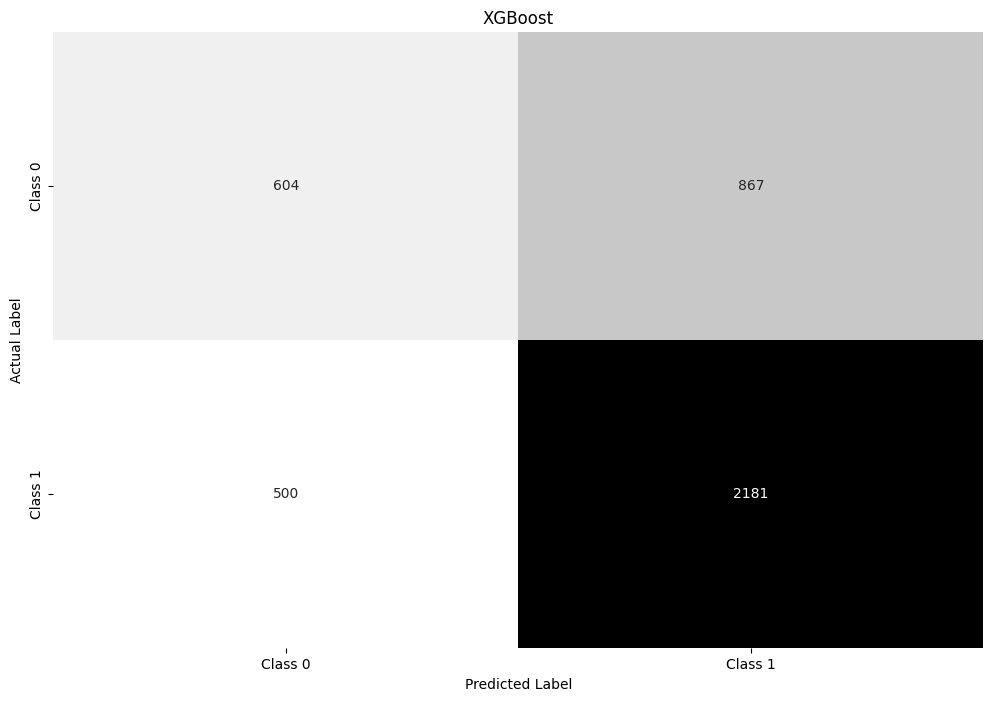

In [23]:
# XGBoost Model
xgb = XGBClassifier(n_estimators=100, random_state=42, use_label_encoder=False, eval_metric='logloss')
xgb.fit(X_train_scaled, Y_train)
xgb_pred = xgb.predict(X_test_scaled)
xgb_accuracy = accuracy_score(Y_test, xgb_pred)
print("XGBoost Accuracy:", xgb_accuracy * 100)
print("XGBoost Classification Report:")
print(classification_report(Y_test, xgb_pred))
plot_confusion_matrix(Y_test, xgb_pred, "XGBoost")



Epoch 1/50
416/416 [==============================] - 10s 9ms/step - loss: 0.6150 - accuracy: 0.6634 - val_loss: 0.5976 - val_accuracy: 0.6701
Epoch 2/50
416/416 [==============================] - 4s 8ms/step - loss: 0.5993 - accuracy: 0.6704 - val_loss: 0.5940 - val_accuracy: 0.6713
Epoch 3/50
416/416 [==============================] - 3s 8ms/step - loss: 0.5968 - accuracy: 0.6737 - val_loss: 0.5914 - val_accuracy: 0.6812
Epoch 4/50
416/416 [==============================] - 3s 8ms/step - loss: 0.5945 - accuracy: 0.6772 - val_loss: 0.5915 - val_accuracy: 0.6830
Epoch 5/50
416/416 [==============================] - 3s 8ms/step - loss: 0.5940 - accuracy: 0.6801 - val_loss: 0.5909 - val_accuracy: 0.6794
Epoch 6/50
416/416 [==============================] - 4s 9ms/step - loss: 0.5935 - accuracy: 0.6820 - val_loss: 0.5904 - val_accuracy: 0.6821
Epoch 7/50
416/416 [==============================] - 3s 8ms/step - loss: 0.5926 - accuracy: 0.6830 - val_loss: 0.5901 - val_accuracy: 0.6818
Epoch

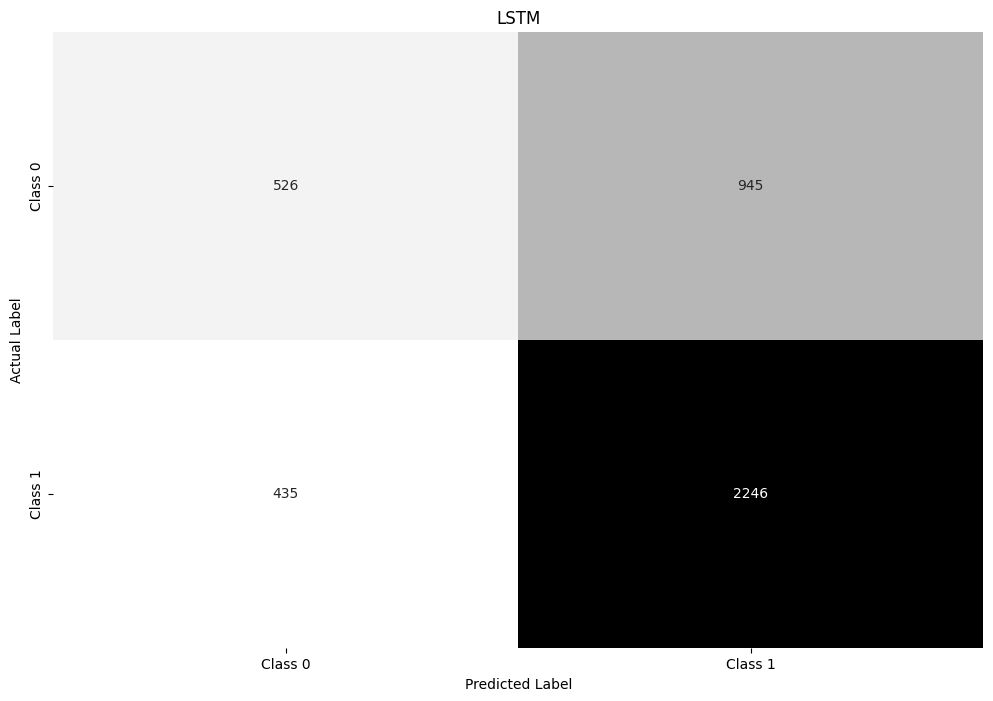

In [24]:
# LSTM Model
X_train_lstm = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_test_lstm = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

lstm_model = Sequential([
    LSTM(64, input_shape=(1, X_train_scaled.shape[1]), return_sequences=True),
    LSTM(32),
    Dense(1, activation='sigmoid')
])

lstm_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history = lstm_model.fit(X_train_lstm, Y_train, epochs=50, batch_size=32, validation_split=0.2, verbose=1)

lstm_pred = (lstm_model.predict(X_test_lstm) > 0.5).astype("int32")
lstm_accuracy = accuracy_score(Y_test, lstm_pred)
print("LSTM Accuracy:", lstm_accuracy * 100)
print("LSTM Classification Report:")
print(classification_report(Y_test, lstm_pred))
plot_confusion_matrix(Y_test, lstm_pred, "LSTM")



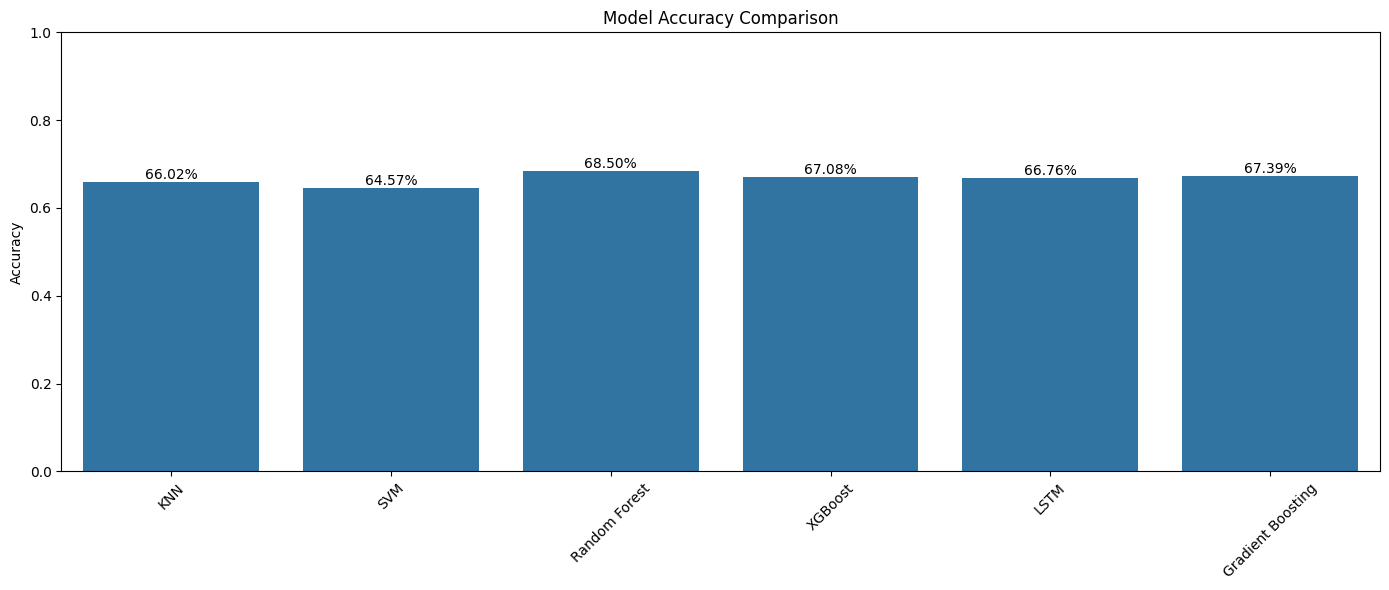

In [25]:
# Compare all models
models = ['KNN', 'SVM', 'Random Forest', 'XGBoost', 'LSTM', 'Gradient Boosting']
accuracies = [knn_accuracy, svm_accuracy, rdf_accuracy, xgb_accuracy, lstm_accuracy, gbc_accuracy]

plt.figure(figsize=(14, 6))
sns.barplot(x=models, y=accuracies)
plt.title("Model Accuracy Comparison")
plt.ylabel("Accuracy")
plt.ylim(0, 1)
plt.xticks(rotation=45)
for i, v in enumerate(accuracies):
    plt.text(i, v, f'{v:.2%}', ha='center', va='bottom')
plt.tight_layout()
plt.show()


In [26]:
# Save models
with open("knn_model.pkl", 'wb') as file:
    pickle.dump(knn, file)
with open("svm_model.pkl", 'wb') as file:
    pickle.dump(svm, file)
with open("random_forest_model.pkl", 'wb') as file:
    pickle.dump(rdf, file)
with open("xgboost_model.pkl", 'wb') as file:
    pickle.dump(xgb, file)
with open("gradient_boosting_model.pkl", 'wb') as file:
    pickle.dump(gbc, file)
lstm_model.save("lstm_model.h5")

print("All models saved successfully")

All models saved successfully


In [27]:
# New code for prediction functionality
try:
    input_log = pd.read_csv('engine_health_log.csv')
except FileNotFoundError:
    input_log = pd.DataFrame(
        columns=['Engine rpm', 'Lub oil pressure', 'Fuel pressure',
                 'Coolant pressure', 'Lub oil temp', 'Coolant temp',
                 'Engine condition']
    )

def predict_engine_health(input_data, model, scaler, log_df):
    input_array = np.array(input_data).reshape(1, -1)

    input_scaled = scaler.transform(input_array)

    if isinstance(model, tf.keras.Model):  # Check if the model is a Keras model (including LSTM)
        input_scaled = input_scaled.reshape((1, 1, input_scaled.shape[1]))
        prediction = model.predict(input_scaled)
        prediction = (prediction > 0.5).astype("int32").flatten()[0]
    else:
        prediction = model.predict(input_scaled)[0]

    if prediction == 0:
        Health_status = "Engine is in good health"
    else:
        Health_status = "Engine is not in good health"

    print(Health_status)

    log_entry = input_data + [int(prediction)]
    log_df.loc[len(log_df)] = log_entry

    return Health_status

# Get user input
input_data = [
    float(input("Enter Engine rpm: ")),
    float(input("Enter Lub oil pressure: ")),
    float(input("Enter Fuel pressure: ")),
    float(input("Enter Coolant pressure: ")),
    float(input("Enter Lub oil temp: ")),
    float(input("Enter Coolant temp: "))
]

model_choice = input("Enter model name (knn/svm/randomforest/xgboost/lstm/gradientboosting): ").strip().lower()

# Load the chosen model
try:
    if model_choice == "knn":
        with open("knn_model.pkl", 'rb') as file:
            model = pickle.load(file)
    elif model_choice == "svm":
        with open("svm_model.pkl", 'rb') as file:
            model = pickle.load(file)
    elif model_choice == "randomforest":
        with open("random_forest_model.pkl", 'rb') as file:
            model = pickle.load(file)
    elif model_choice == "xgboost":
        with open("xgboost_model.pkl", 'rb') as file:
            model = pickle.load(file)
    elif model_choice == "lstm":
        model = load_model("lstm_model.h5")
    elif model_choice == "gradientboosting":
        with open("gradient_boosting_model.pkl", 'rb') as file:
            model = pickle.load(file)
    else:
        print("Invalid model name")
        model = None
except Exception as e:
    print(f"Error loading model: {e}")
    model = None

if model:
    result = predict_engine_health(input_data, model, scaler, input_log)
    print(result)
else:
    print("Unable to make prediction due to model loading error.")

# Save the updated log
input_log.to_csv('engine_health_log.csv', index=False)

Engine is in good health
Engine is in good health


C:\Users\srini\AppData\Roaming\Python\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [28]:
input_log

,Engine rpm,Lub oil pressure,Fuel pressure,Coolant pressure,Lub oil temp,Coolant temp,Engine condition
0,5400.0,45.0,54.0,8.0,55.0,44.0,1.0
1,8000.0,4.0,4.0,4.0,45.0,78.0,0.0
2,6000.0,6.0,6.0,6.0,65.0,65.0,0.0


In [ ]:
!pip install streamlit

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 55.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 76.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.9/82.9 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 3.7 MB/s eta 0:00:00
  Attempting uninstall: tenacity
    Found existing installation: tenacity 9.0.0
    Uninstalling tenacity-9.0.0:
      Successfully uninstalled tenacity-9.0.0


In [ ]:
%%writefile app.py
import streamlit as st
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense

# Load models (use st.cache_resource to cache models as they're large and resource-heavy)
@st.cache_resource
def load_model_files():
    with open("knn_model.pkl", 'rb') as file:
        knn = pickle.load(file)
    with open("svm_model.pkl", 'rb') as file:
        svm = pickle.load(file)
    with open("random_forest_model.pkl", 'rb') as file:
        rdf = pickle.load(file)
    with open("xgboost_model.pkl", 'rb') as file:
        xgb = pickle.load(file)
    with open("gradient_boosting_model.pkl", 'rb') as file:
        gbc = pickle.load(file)
    lstm = load_model("lstm_model.h5")
    return knn, svm, rdf, xgb, gbc, lstm

# Load data (use st.cache_data for lightweight caching of the dataset)
@st.cache_data
def load_data():
    return pd.read_csv("/content/engine_data.csv")

# Prepare the prediction function
def predict_engine_health(input_data, model, scaler):
    input_array = np.array(input_data).reshape(1, -1)
    input_scaled = scaler.transform(input_array)
    if isinstance(model, tf.keras.Model):  # Check if the model is a Keras model (including LSTM)
        input_scaled = input_scaled.reshape((1, 1, input_scaled.shape[1]))
        prediction = model.predict(input_scaled)
        prediction = (prediction > 0.5).astype("int32").flatten()[0]
    else:
        prediction = model.predict(input_scaled)[0]
    return "Engine is in good health" if prediction == 0 else "Engine is not in good health"

# Main app
def main():
    st.title("Engine Health Prediction App")

    # Load data and models
    df = load_data()
    knn, svm, rdf, xgb, gbc, lstm = load_model_files()

    # Sidebar for user input
    st.sidebar.header("Input Engine Parameters")
    engine_rpm = st.sidebar.number_input("Enter Engine rpm", min_value=0.0, step=0.1)
    lub_oil_pressure = st.sidebar.number_input("Enter Lub Oil Pressure", min_value=0.0, step=0.1)
    fuel_pressure = st.sidebar.number_input("Enter Fuel Pressure", min_value=0.0, step=0.1)
    coolant_pressure = st.sidebar.number_input("Enter Coolant Pressure", min_value=0.0, step=0.1)
    lub_oil_temp = st.sidebar.number_input("Enter Lub Oil Temperature", min_value=0.0, step=0.1)
    coolant_temp = st.sidebar.number_input("Enter Coolant Temperature", min_value=0.0, step=0.1)

    input_data = [engine_rpm, lub_oil_pressure, fuel_pressure, coolant_pressure, lub_oil_temp, coolant_temp]

    # Model selection
    model_choice = st.sidebar.selectbox("Choose a model", ['KNN', 'SVM', 'Random Forest', 'XGBoost', 'LSTM', 'Gradient Boosting'])

    # Load appropriate model
    if model_choice == "KNN":
        model = knn
    elif model_choice == "SVM":
        model = svm
    elif model_choice == "Random Forest":
        model = rdf
    elif model_choice == "XGBoost":
        model = xgb
    elif model_choice == "LSTM":
        model = lstm
    elif model_choice == "Gradient Boosting":
        model = gbc

    # Scale the input
    scaler = StandardScaler()
    scaler.fit(df.drop(columns=["Engine Condition"]))  # assuming "Engine Condition" is the target column

    if st.button("Predict"):
        result = predict_engine_health(input_data, model, scaler)
        st.write(f"Prediction: {result}")

    # Display Dataset
    if st.checkbox("Show Dataset"):
        st.write(df.head())

    # Plot correlation heatmap
    if st.checkbox("Show Correlation Heatmap"):
        correlation = df.corr()
        fig, ax = plt.subplots(figsize=(12, 8))
        sns.heatmap(correlation, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5, ax=ax)
        st.pyplot(fig)

if __name__ == '__main__':
    main()


Writing app.py


In [ ]:
!wget -q -O - https://loca.lt/mytunnelpassword

35.237.153.35

In [ ]:
!streamlit run app.py & npx localtunnel --port 8501




  You can now view your Streamlit app in your browser.

  Local URL: http://localhost:8501
  Network URL: http://172.28.0.2:8501
  External URL: http://35.237.153.35:8501

Need to install the following packages:
  localtunnel@2.0.2
Ok to proceed? (y) y
your url is: https://solid-rules-brush.loca.lt
2024-09-28 05:32:16.835733: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-28 05:32:16.887509: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-28 05:32:16.903054: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-28 05:32:18.804651: W tensorflow/compiler/tf2tensorrt/